In [15]:
from __future__ import division, print_function, absolute_import

import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression
import numpy as np
import matplotlib.pyplot as plt
import sklearn.utils
import tensorflow as tf
import h5py
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

%matplotlib inline

In [16]:
IMG_WIDTH = 32 # Side for each transformed Image
IMG_HEIGHT = 32
IMG_DEPTH = 1 # RGB files

In [17]:
MAX_DIGITS = 5

In [18]:
imgsAll = np.empty(shape = (0,IMG_HEIGHT, IMG_WIDTH), dtype=float)
labelsAll = np.empty(shape = (0,MAX_DIGITS), dtype=float)
numDigitsAll = np.empty(shape = (0), dtype=float)

In [19]:
for numDigits in range(1,MAX_DIGITS + 1):
    h5FileName = 'svhn_' + str(numDigits) + '.h5'
    data = h5py.File(h5FileName)
    imgs = np.array(data['images']).astype(float)
    labels = np.array(data['digits'])
    # Buff up labels to MAX_DIGITS width
    zerosToFill = np.zeros(shape = (labels.shape[0], MAX_DIGITS - numDigits ), dtype = float)
    labels = np.concatenate ((labels, zerosToFill), axis = 1)
    # Concat to full Dataset
    imgsAll = np.concatenate((imgsAll, imgs), axis = 0)
    labelsAll = np.concatenate((labelsAll, labels), axis = 0)
    numDigitsAll = np.concatenate((numDigitsAll, np.full(labels.shape[0], numDigits, dtype= float))) # Add num of digits for this set of images

In [20]:
print (imgsAll.shape)
print (labelsAll.shape)
print (numDigitsAll.shape)

(202353, 32, 32)
(202353, 5)
(202353,)


[ 4.  6.  8.  0.  0.]
3.0


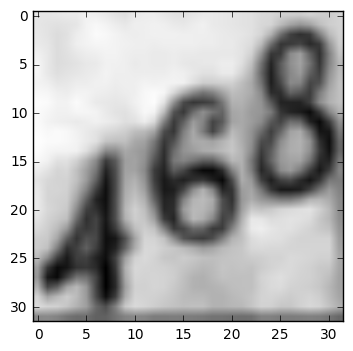

In [21]:
print (labelsAll[100000])
plt.imshow(imgsAll[100000], cmap='gray')
print (numDigitsAll[100000])

In [22]:
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    index_update = [int(x) for x in index_offset + labels_dense]
    labels_one_hot.flat[index_update] = 1
    return labels_one_hot

In [23]:
# Get the dataset
X = imgsAll.reshape([-1, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH])
Y = numDigitsAll

In [25]:
X, Y = sklearn.utils.shuffle(X, Y, random_state=0)

In [26]:
# Generate validation set
ratio = 0.9 # Train/Test set
randIdx = np.random.random(imgsAll.shape[0]) <= ratio
#print (sum(map(lambda x: int(x), randIdx)))
X_train = X[randIdx]
Y_train = Y[randIdx]
X_test = X[randIdx == False]
Y_test = Y[randIdx == False]
Y_train = dense_to_one_hot(Y_train, num_classes = MAX_DIGITS+1)
Y_test = dense_to_one_hot(Y_test, num_classes = MAX_DIGITS+1)
#del X, Y # release some space

In [27]:
print (X_train.shape)
print (Y_train.shape)

(182281, 32, 32, 1)
(182281, 6)


Training Step: 2849  | total loss: 0.13426
| Adam | epoch: 001 | loss: 0.13426 - acc: 0.9623 | val_loss: 0.09992 - val_acc: 0.9688 -- iter: 182281/182281
Training Step: 2849  | total loss: 0.13426
| Adam | epoch: 001 | loss: 0.13426 - acc: 0.9623 | val_loss: 0.09992 - val_acc: 0.9688 -- iter: 182281/182281
--


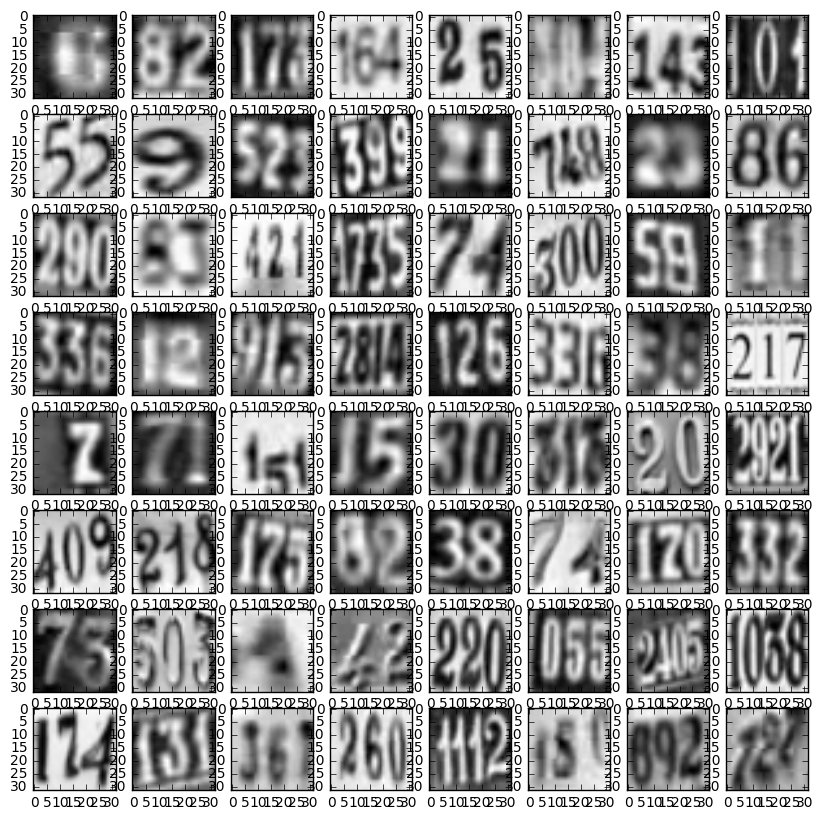

In [28]:
# Building convolutional network

with tf.Graph().as_default():
   # Building convolutional network
    # Real-time data preprocessing
    img_prep = ImagePreprocessing()
    img_prep.add_featurewise_zero_center()
    img_prep.add_featurewise_stdnorm()

    # Real-time data augmentation
    img_aug = ImageAugmentation()
    #img_aug.add_random_flip_leftright()
    img_aug.add_random_rotation(max_angle=25.)
    network = input_data(shape=[None, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH], name='input',
                                             data_preprocessing=img_prep,
                                             data_augmentation=img_aug)
    network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
    network = max_pool_2d(network, 2)
    network = local_response_normalization(network)
    network = conv_2d(network, 64, 3, activation='relu', regularizer="L2")
    network = max_pool_2d(network, 2)
    network = local_response_normalization(network)
    fc_1 = fully_connected(network, 1024, activation='tanh')
    softmax1 = fully_connected(fc_1, MAX_DIGITS + 1, activation='softmax')

    network = regression(softmax1, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy', name='target')
    
    model = tflearn.DNN(network, tensorboard_verbose=3)
    model.fit({'input': X_train}, Y_train, 
              validation_set= (X_test, Y_test), n_epoch=1, snapshot_step=100, show_metric=True, run_id='convnet_svhn_numDigits')
    numImgEachAxis = 8
    f,ax = plt.subplots(numImgEachAxis, numImgEachAxis, figsize=(10,10))
    for i in range(numImgEachAxis):
        for j in range(numImgEachAxis):
            #res = np.array([np.argmax(x) for x in model.predict([X_train[i*numImgEachAxis + j]])])
            #print (str(i) + ',' + str(j) + ' -> ' +str(res))
            #ax[i][j].set_title(str([np.round(x,2) for x in res]))
            ax[i][j].imshow(X_train[i*numImgEachAxis + j].reshape((IMG_HEIGHT,IMG_WIDTH)) ,cmap = 'gray')
    plt.show() # or display.display(plt.gcf()) if you prefer
#    print (model.evaluate(X_test,feedTestList))